In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/Users/aarsh/Documents/Applied Machine Learning/ Sales Project/rossmann-store-sales')

In [2]:
store=pd.read_csv('Store.csv',parse_dates=True)
train=pd.read_csv('train.csv',parse_dates=[2])
test=pd.read_csv('test.csv',parse_dates=[3])

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [4]:
store.isnull().any()

Store                        False
StoreType                    False
Assortment                   False
CompetitionDistance           True
CompetitionOpenSinceMonth     True
CompetitionOpenSinceYear      True
Promo2                       False
Promo2SinceWeek               True
Promo2SinceYear               True
PromoInterval                 True
dtype: bool

In [5]:
store.loc[store.CompetitionOpenSinceMonth.isnull(),"CompetitionOpenSinceMonth"]=store["CompetitionOpenSinceMonth"].mean()
store.loc[store.CompetitionOpenSinceYear.isnull(),"CompetitionOpenSinceYear"]=store["CompetitionOpenSinceYear"].mean()
store.fillna(0,inplace=True)

In [6]:
train.isnull().any()

Store            False
DayOfWeek        False
Date             False
Sales            False
Customers        False
Open             False
Promo            False
StateHoliday     False
SchoolHoliday    False
dtype: bool

In [7]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [8]:
test[test['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [9]:
test.fillna(1,inplace=True)

In [10]:
np.sum([train["Sales"]==0])

172871

In [11]:
data=pd.merge(train,store,on='Store')
test_data=pd.merge(test,store,on='Store')
data=data[(data.Open!=0) & (data.Sales>0)]
test_data=test_data[test_data.Open==1]


In [12]:
def data_processing(data):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
#competitor open time in months
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
#promo2 open time in months
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
 # Indicate whether the month is in promo interval
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1) 
    return data
data=data_processing(data)
test_data=data_processing(test_data)
                                                

In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35104 entries, 0 to 41087
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Id                         35104 non-null  int64         
 1   Store                      35104 non-null  int64         
 2   DayOfWeek                  35104 non-null  int64         
 3   Date                       35104 non-null  datetime64[ns]
 4   Open                       35104 non-null  float64       
 5   Promo                      35104 non-null  int64         
 6   StateHoliday               35104 non-null  int64         
 7   SchoolHoliday              35104 non-null  int64         
 8   StoreType                  35104 non-null  int64         
 9   Assortment                 35104 non-null  int64         
 10  CompetitionDistance        35104 non-null  float64       
 11  CompetitionOpenSinceMonth  35104 non-null  float64       
 12  Comp

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  int64         
 8   SchoolHoliday              844338 non-null  int64         
 9   StoreType                  844338 non-null  int64         
 10  Assortment                 844338 non-null  int64         
 11  CompetitionDistance        844338 non-null  float64

In [ ]:
features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Year', 'Month',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen','IsPromoMonth']
target='Sales'

Checking correlation between features

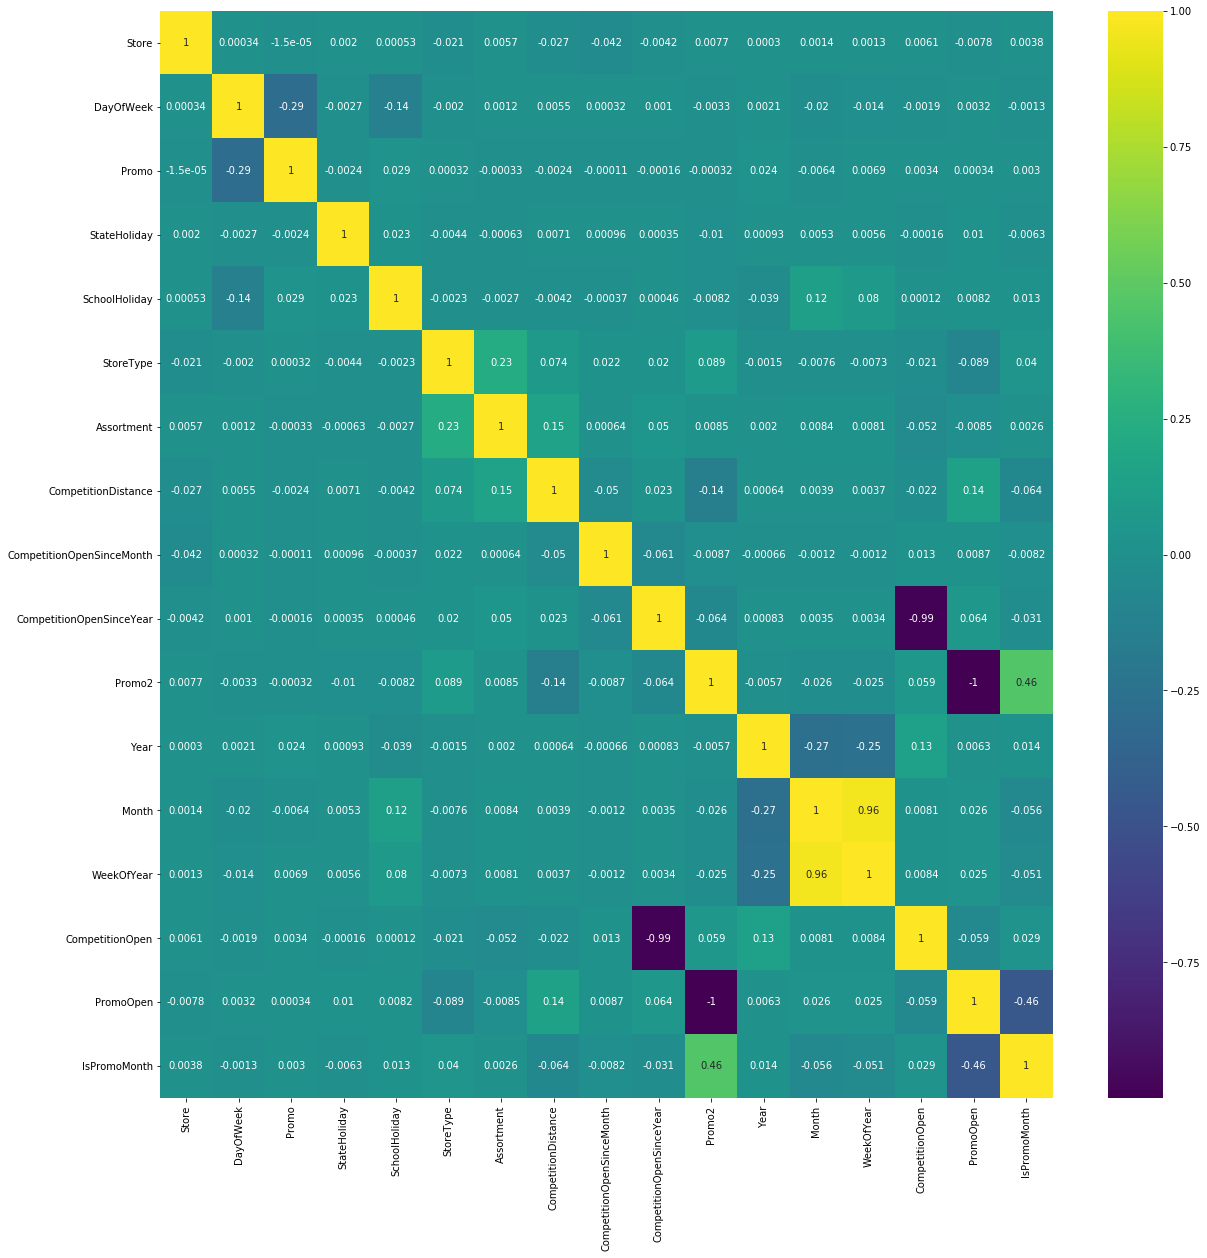

In [16]:
k=20
cols=data[features].corr()
plt.figure(figsize=(20,20))
sns.heatmap(cols,annot=True,cmap='viridis')
plt.show()

Applying log transformation to the target variable as it was right-skewed

In [17]:
X=data[features]
y=np.log(data["Sales"]+1)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=0)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((633253, 17), (211085, 17), (633253,), (211085,))

Defining Evaluation metrics 

In [18]:
def evaluation(model,X_test,y_test):
    from sklearn.metrics import mean_squared_error,r2_score as MSE,r2_score
    y_pred=model.predict(X_test)
    y_pred=np.exp(y_pred)-1
    y_test_c=np.exp(y_test)-1
    RMSE=MSE(y_test_c,y_pred)**1/2
    rmspe = (np.sqrt(np.mean(np.square((y_test_c - y_pred) / y_test_c)))) * 100
    r2_score=r2_score(y_test_c,y_pred)
    return (RMSE,r2_score,rmspe)

Creating a baseline model using Random Forest

In [33]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=8)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=8, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

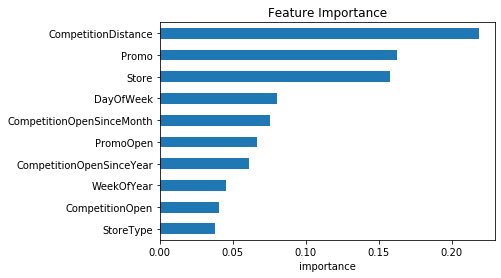

In [40]:
#plotting feature importances
feat_importance = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importance.nlargest(10).sort_values(ascending = True).plot(kind='barh')
plt.xlabel('importance')
plt.title('Feature Importance')
plt.show()

In [38]:
print("Root-mean-square-error,R2-error,Root-Mean-Squared-Percentage-error",evaluation(rf,X_test,y_test))

Root-mean-square-error,R2-error,Root-Mean-Squared-Percentage-error (0.4407601351606292, 0.8815202703212583, 15.527182332307982)


# Hyperparameter Tuning

In [22]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 50, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 15, num = 7)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10,
                               cv = 3, verbose=2,random_state=0,return_train_score=True
                               ,n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
best_random = rf_random.best_estimator_
print(rf_random.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  4.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.0min finished


{'n_estimators': 40, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [39]:
print("Root-mean-square-error,R2-error,Root-mean-squared-percentage-error",evaluation(best_random,X_test,y_test))

Root-mean-square-error,R2-error,Root-mean-squared-percentage-error (0.44346114260955793, 0.8869222852191159, 14.569761088899295)


In [24]:
model_results = pd.DataFrame(rf_random.cv_results_).sort_values(by='mean_test_score' , ascending=False)
model_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
9,65.189207,0.219096,7.663637,0.090280,40,sqrt,None,True,"{'n_estimators': 40, 'max_features': 'sqrt', '...",0.886999,0.888556,0.889229,0.888261,0.000934,1,0.983258,0.983102,0.983058,0.983139,0.000086
1,87.593739,0.081751,1.521246,0.014726,46,sqrt,11,False,"{'n_estimators': 46, 'max_features': 'sqrt', '...",0.506412,0.504641,0.507487,0.506180,0.001174,2,0.516064,0.514338,0.512776,0.514393,0.001343
6,124.188464,0.094264,0.636102,0.006166,20,auto,11,False,"{'n_estimators': 20, 'max_features': 'auto', '...",0.484806,0.493801,0.503095,0.493901,0.007467,3,0.499575,0.503291,0.509508,0.504125,0.004098
3,152.828889,0.207375,1.101602,0.018271,36,auto,10,True,"{'n_estimators': 36, 'max_features': 'auto', '...",0.477132,0.492606,0.491102,0.486947,0.006967,4,0.487510,0.498671,0.494945,0.493709,0.004639
5,124.329907,0.248136,0.924791,0.049492,30,auto,10,True,"{'n_estimators': 30, 'max_features': 'auto', '...",0.476632,0.491696,0.489918,0.486082,0.006722,5,0.487109,0.497662,0.493845,0.492872,0.004363
7,202.655150,0.104900,0.821921,0.017382,46,auto,10,False,"{'n_estimators': 46, 'max_features': 'auto', '...",0.442153,0.443600,0.453883,0.446545,0.005222,6,0.454114,0.451608,0.458467,0.454729,0.002834
4,54.703350,0.190972,0.919870,0.025810,40,sqrt,8,False,"{'n_estimators': 40, 'max_features': 'sqrt', '...",0.366693,0.362665,0.366876,0.365411,0.001943,7,0.370430,0.366523,0.366124,0.367692,0.001943
0,87.180902,0.066404,0.431281,0.012112,23,auto,6,False,"{'n_estimators': 23, 'max_features': 'auto', '...",0.292885,0.295323,0.291683,0.293297,0.001515,8,0.297416,0.297342,0.289810,0.294856,0.003568
8,107.305092,0.231997,0.590265,0.047977,43,auto,5,False,"{'n_estimators': 43, 'max_features': 'auto', '...",0.264765,0.263332,0.265736,0.264611,0.000987,9,0.266004,0.266390,0.264255,0.265550,0.000929
2,30.116592,0.047947,0.668517,0.008265,36,sqrt,5,True,"{'n_estimators': 36, 'max_features': 'sqrt', '...",0.262657,0.258454,0.260751,0.260621,0.001718,10,0.263502,0.260547,0.259020,0.261023,0.001860


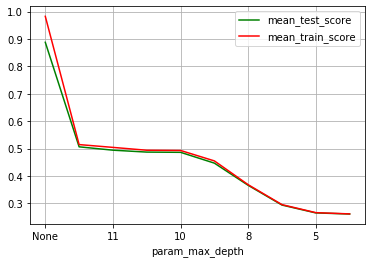

In [25]:
model_results.set_index('param_max_depth')['mean_test_score'].plot(color='g',legend=True)
model_results.set_index('param_max_depth')['mean_train_score'].plot(color='r' , legend=True)
plt.grid(True)
plt.show()

We can see that the model underfits when max depth<8 and overfits when max depth>9, so we can set max depth=9.Also their is a  change in percentage error.

# Making predictions on the test data

In [26]:
test_pred=best_random.predict(test_data[X_train.columns])
test_pred=np.exp(test_pred)-1

In [27]:
test_pred

array([ 4700.58301722,  4956.67684774,  4982.81408842, ...,
        7508.80512666, 10269.6437656 ,  7490.87280748])

In [32]:
submission = pd.DataFrame({'Id' : test_data['Id'] , 'Sales' : test_pred})
submission['Sales'] = submission['Sales'].astype(int)
submission['Id']= submission.index
submission['Id'] = submission['Id']+1
submission.head()

,Id,Sales
0,1,4700
1,2,4956
2,3,4982
3,4,5867
5,6,4221


In [37]:
submission.to_csv('/Users/aarsh/Documents/Applied Machine Learning/ Sales Project/Submission.csv',index=False)